# 量子機械学習


Kifumi Numata (Aug 02, 2022)

In [1]:
import numpy as np

# 描画のため
import matplotlib.pyplot as plt

# Scikit-learnのインポート(Python用の機械学習ライブラリー)
from sklearn import datasets
from sklearn.model_selection import train_test_split # データ分割
from sklearn.svm import SVC # SVM Classification(SVM分類)
from sklearn.decomposition import PCA # Principal component analysis(主成分分析)
from sklearn.preprocessing import StandardScaler, MinMaxScaler # 標準化、正規化のスケール変換

# Qiskitのインポート
from qiskit import Aer, execute
from qiskit.circuit import QuantumCircuit, Parameter, ParameterVector
from qiskit.circuit.library import PauliFeatureMap, ZFeatureMap, ZZFeatureMap
from qiskit_machine_learning.kernels import QuantumKernel

## データを用意

ここでは，手書き数字画像のデータセット(MNISTデータセット)から0と1のサブセットを扱います。

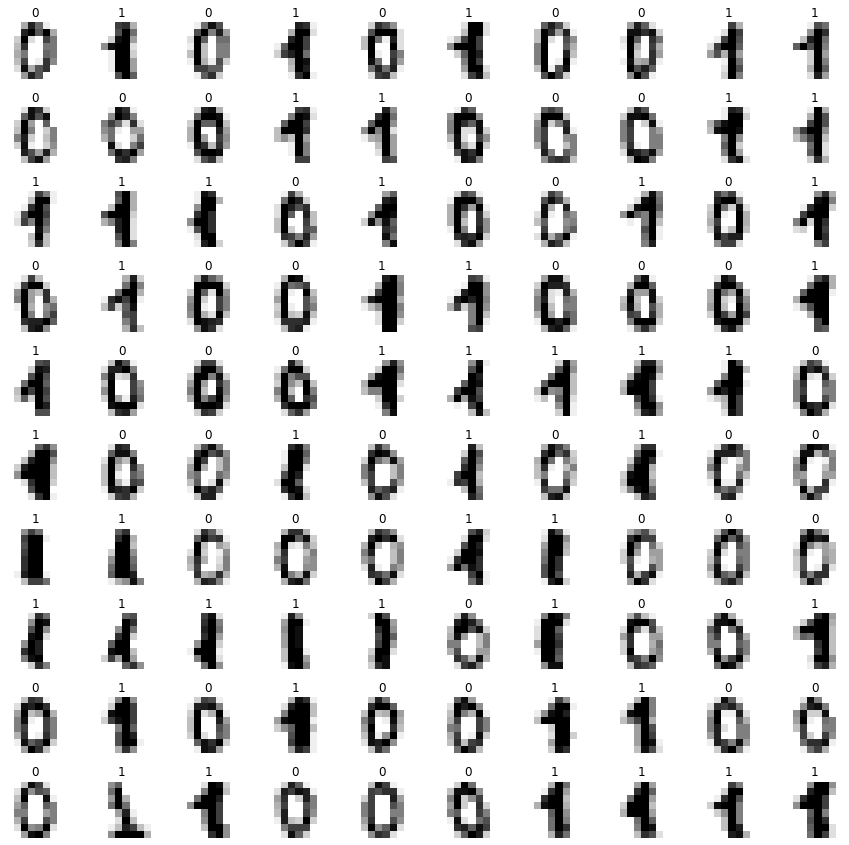

In [2]:
# 数字データセットから2クラスのデータ(0と1)を読み込み
digits = datasets.load_digits(n_class=2)   

# 読み込んだ画像の最初の100枚をプロット
fig, axes = plt.subplots(10, 10, figsize=(15, 15), subplot_kw={'xticks':[], 'yticks':[]}, gridspec_kw=dict(hspace=0.5, wspace=0.5))
for i, ax in enumerate(axes.flat):
    ax.set_axis_off()
    ax.imshow(digits.images[i], cmap=plt.cm.gray_r, interpolation='nearest')
    ax.set_title(digits.target[i])

このデータセットには、合計360個のデータが含まれています。各データポイントは、8×8の数字の画像で、配列になっていて、各要素は0（白）から16（黒）までの整数です。古典的な分類アルゴリズムの際と同様に、データセットを学習用（100）とテスト用（20）のサンプルに分割し、正規化する必要があります。このデータセットを量子分類アルゴリズムに用いるために、範囲を-1から1の間にスケーリングし、次元を使用する量子ビット数（今回は4）に縮小します。

In [3]:
print(digits.images[0])

[[ 0.  0.  5. 13.  9.  1.  0.  0.]
 [ 0.  0. 13. 15. 10. 15.  5.  0.]
 [ 0.  3. 15.  2.  0. 11.  8.  0.]
 [ 0.  4. 12.  0.  0.  8.  8.  0.]
 [ 0.  5.  8.  0.  0.  9.  8.  0.]
 [ 0.  4. 11.  0.  1. 12.  7.  0.]
 [ 0.  2. 14.  5. 10. 12.  0.  0.]
 [ 0.  0.  6. 13. 10.  0.  0.  0.]]


In [4]:
# データセットの分割
sample_train, sample_test, labels_train, labels_test = train_test_split(
     digits.data, digits.target, test_size=0.2, random_state=22)

# 次元削除
n_dim = 4
pca = PCA(n_components=n_dim).fit(sample_train)
sample_train = pca.transform(sample_train)
sample_test = pca.transform(sample_test)

# 標準化
std_scale = StandardScaler().fit(sample_train)
sample_train = std_scale.transform(sample_train)
sample_test = std_scale.transform(sample_test)

# 正規化
samples = np.append(sample_train, sample_test, axis=0)
minmax_scale = MinMaxScaler((-1, 1)).fit(samples)
sample_train = minmax_scale.transform(sample_train)
sample_test = minmax_scale.transform(sample_test)

# 学習用100個とテスト用20個を選択
train_size = 100
sample_train = sample_train[:train_size]
labels_train = labels_train[:train_size]

test_size = 20
sample_test = sample_test[:test_size]
labels_test = labels_test[:test_size]

In [5]:
# 一つ目のデータをそれぞれ表示
print(sample_train[0], labels_train[0])
print(sample_test[0], labels_test[0])

[-0.79923362 -0.26571862 -0.16474421 -0.17815209] 0
[ 0.41948352 -0.83602799  0.72200828 -0.373356  ] 1


## データ符号化(エンコード)

この古典データを、量子特徴量マップ(ZZFeatureMap)を用いて量子状態空間にエンコードしていきます。

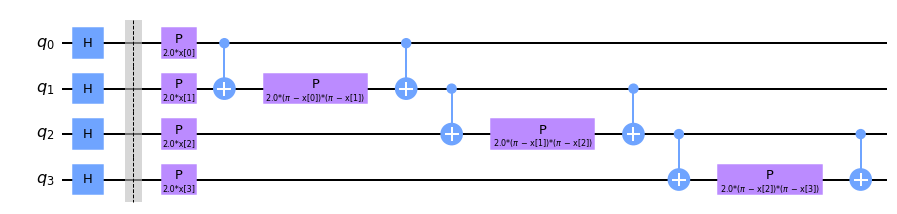

In [6]:
# 4特徴量、深さ(繰り返し数)1のZZFeatureMap
zz_map = ZZFeatureMap(feature_dimension=4, reps=1, entanglement='linear', insert_barriers=True)
zz_map.decompose().draw('mpl')

## 量子カーネル計算

量子特徴マップ$\phi(\vec{x})$は、量子カーネル$k(\vec{x}_i,\vec{x}_j)= \phi(\vec{x}_j)^\dagger\phi(\vec{x}_i)$を作ることができます。これは類似性の尺度と考えることができ、$\vec{x}_i$ と $\vec{x}_j$が近いときに大きくなります。

今回は、ZZFeatureMapを使って量子カーネルを計算します。

In [7]:
zz_kernel = QuantumKernel(feature_map=zz_map, quantum_instance=Aer.get_backend('statevector_simulator'))

訓練データの0個目と1個目のデータについて、量子カーネルを計算する量子回路を作成し、実際に計算してみます。

In [8]:
print(sample_train[0])
print(sample_train[1])

[-0.79923362 -0.26571862 -0.16474421 -0.17815209]
[-0.81630337 -0.2918343  -0.48757339 -0.44903275]


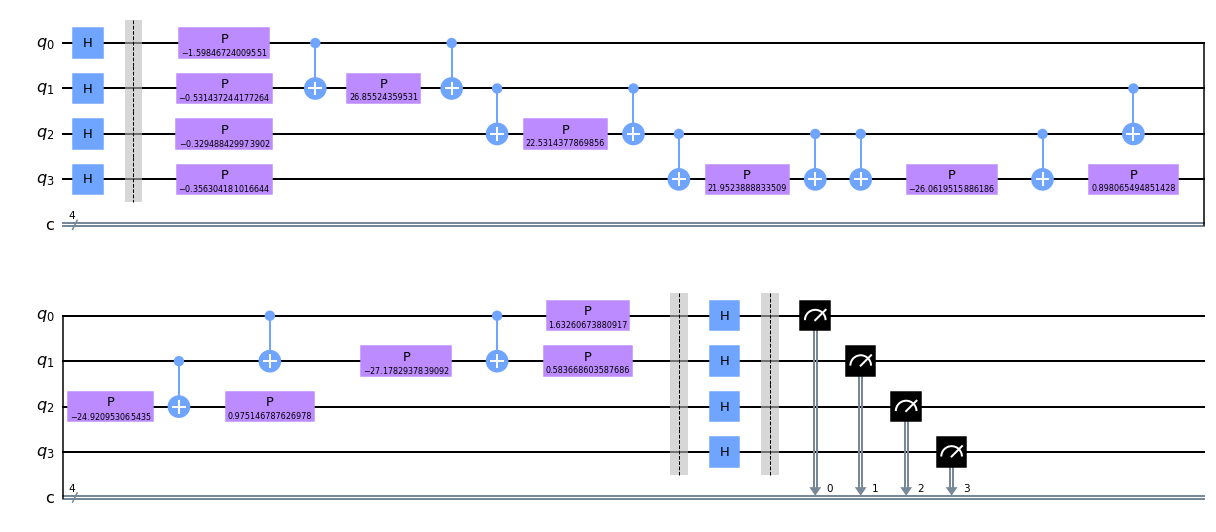

In [9]:
zz_circuit = zz_kernel.construct_circuit(sample_train[0], sample_train[1])
zz_circuit.decompose().decompose().draw(output='mpl')

各回転ゲートのパラメーター値は少し読みにくいですが、回路が対称になっていることが分かると思います。左半分は訓練データsample_train[0]が、右半分は訓練データsample_train[1]がコード化されています。

例として、上記の量子カーネルを測定し、ゼロ状態のカウント数の割合として、カーネル行列の要素（訓練データの0個目と1個目のデータについて）を計算します。

In [10]:
backend = Aer.get_backend('qasm_simulator')
job = execute(zz_circuit, backend, shots=8192, 
              seed_simulator=1024, seed_transpiler=1024)
counts = job.result().get_counts(zz_circuit)

In [11]:
counts['0000']/sum(counts.values())

0.0244140625

このプロセスを，学習データサンプルのペアごとに繰り返して学習カーネル行列を埋め，学習データサンプルとテストデータサンプルの間で繰り返してテストカーネル行列を埋めていきます。なお，各行列は対称形であるため，計算時間を短縮するために，要素の半分だけを計算しています。

訓練データとテストデータについて、QuantumKernelクラスを使ってカーネル行列を計算します。

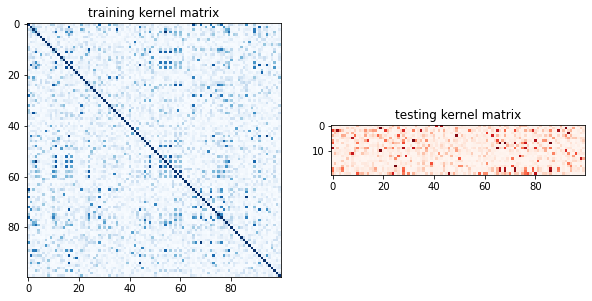

In [12]:
matrix_train = zz_kernel.evaluate(x_vec=sample_train)
matrix_test = zz_kernel.evaluate(x_vec=sample_test, y_vec=sample_train)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(np.asmatrix(matrix_train),
              interpolation='nearest', origin='upper', cmap='Blues')
axs[0].set_title("training kernel matrix")
axs[1].imshow(np.asmatrix(matrix_test),
              interpolation='nearest', origin='upper', cmap='Reds')
axs[1].set_title("testing kernel matrix")
plt.show()

## 学習
古典SVM分類器`scikit-learn`の`svc`アルゴリズムを使って学習し、テストデータで学習率を見てみます。

In [13]:
zzpc_svc = SVC(kernel='precomputed')
zzpc_svc.fit(matrix_train, labels_train)    # 学習
zzpc_score = zzpc_svc.score(matrix_test, labels_test)    # 正解率を判定

print(f'Kernel classification test score: {zzpc_score}')


Kernel classification test score: 1.0


テストデータポイントをほぼ正しく分類できていることがわかります。

# 洋服画像データの分類


ここで扱うデータは，MNISTデータセットの亜種である[Fashion-MNIST](https://github.com/zalandoresearch/fashion-mnist/blob/master/README.ja.md)という洋服画像データセットのサブセットです。


<center><div><img src="fashion-mnist-sprite.png" width="640" /></div></center>

Image source:[Fashion-MNIST](https://github.com/zalandoresearch/fashion-mnist/blob/master/README.ja.md)

以下のラベルの画像について分類します。

- label 2: プルオーバー
- label 3: ドレス

まずデータセットを読み込んで，クラスごとに1枚ずつ画像を表示してみます。

In [14]:
# General imports
import os
import gzip
import numpy as np
import matplotlib.pyplot as plt
from pylab import cm
import warnings

warnings.filterwarnings("ignore")

# Scikit-learnのインポート(Python用の機械学習ライブラリー)
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Qiskitのインポート
from qiskit import Aer, execute
from qiskit.circuit import QuantumCircuit, Parameter, ParameterVector
from qiskit.circuit.library import PauliFeatureMap, ZFeatureMap, ZZFeatureMap
from qiskit.circuit.library import TwoLocal, NLocal, RealAmplitudes, EfficientSU2
from qiskit.circuit.library import HGate, RXGate, RYGate, RZGate, CXGate, CRXGate, CRZGate
from qiskit_machine_learning.kernels import QuantumKernel

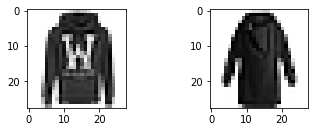

In [15]:
# データのロード
DATA_PATH = 'fashion.npz'
data = np.load(DATA_PATH)

sample_train = data['sample_train']
labels_train = data['labels_train']
sample_test = data['sample_test']

# データセットの分割
sample_train, sample_test, labels_train, labels_test = train_test_split(
    sample_train, labels_train, test_size=0.2, random_state=42)

# データの表示
fig = plt.figure()
LABELS = [2,3]
num_labels = len(LABELS)
for i in range(num_labels):
    ax = fig.add_subplot(2, num_labels, i+1)
    img = sample_train[labels_train==LABELS[i]][0].reshape((28, 28))
    ax.imshow(img, cmap="Greys")

次に，以下のデータセットの前処理をします

- 標準化
- 主成分分析(PCA)による次元圧縮
- 正規化

なおN_DIMを変えることで，次元数を変えることができます。

In [16]:
# 次元削除
N_DIM = 4
pca = PCA(n_components=N_DIM).fit(sample_train)
sample_train = pca.transform(sample_train)
sample_test = pca.transform(sample_test)

# 標準化
std_scale = StandardScaler().fit(sample_train)
sample_train = std_scale.transform(sample_train)
sample_test = std_scale.transform(sample_test)

# 正規化
samples = np.append(sample_train, sample_test, axis=0)
minmax_scale = MinMaxScaler((-1, 1)).fit(samples)
sample_train = minmax_scale.transform(sample_train)
sample_test = minmax_scale.transform(sample_test)

In [17]:
# 一つ目のデータをそれぞれ表示
print(sample_train[0], labels_train[0])
print(sample_test[0], labels_test[0])

[ 0.6363233  -0.2027854  -0.20199084 -0.61952027] 2
[-0.21931836 -1.         -0.08839212 -0.08617034] 3


## 演習

この洋服画像データについて、特徴量マップ(ZZFeatureMap)と量子カーネル(QuantumKernelクラス)を使ってカーネル行列を計算し、古典のSVMを使って学習してみます。学習率を確認してみましょう。

In [ ]:
zz_map = # コードを入れてください
zz_map.decompose().draw('mpl')

In [ ]:
zz_kernel = # コードを入れてください

In [ ]:
print(sample_train[0])
print(sample_train[1])

In [ ]:
zz_circuit = zz_kernel.construct_circuit(sample_train[0], sample_train[1])
zz_circuit.decompose().decompose().draw(output='mpl') 

In [ ]:
backend = Aer.get_backend('qasm_simulator')
job = execute(zz_circuit, backend, shots=8192, 
              seed_simulator=1024, seed_transpiler=1024)
counts = job.result().get_counts(zz_circuit)

In [ ]:
counts['0000']/sum(counts.values())

訓練データとテストデータについて、QuantumKernelクラスを使ってカーネル行列を計算します。

In [ ]:
matrix_train = # コードを入れてください
matrix_test = # コードを入れてください

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(np.asmatrix(matrix_train),
              interpolation='nearest', origin='upper', cmap='Blues')
axs[0].set_title("training kernel matrix")
axs[1].imshow(np.asmatrix(matrix_test),
              interpolation='nearest', origin='upper', cmap='Reds')
axs[1].set_title("testing kernel matrix")
plt.show()

古典SVM分類器`scikit-learn`の`svc`アルゴリズムを使って学習し、テストデータで学習率を見てみます。

In [ ]:
zzpc_svc = # コードを入れてください
zzpc_svc.fit(matrix_train, labels_train)
zzpc_score = # コードを入れてください

print(f'Kernel classification test score: {zzpc_score}')